# A Generátor látens terében való keresés

Látens térben való keresés gradiens módszerrel

hibafüggvény: az L2 távolság minimalizálása

Jelölje $X$ a keresendő képet, $G$ a generátort, $\vec{z}$ pedig a látens vektort.

A cél egy olyan $\vec{z} \in \mathbb{R}^{100}$ látens vektor keresése, amellyel a lenti távolság minimalizálható.

$$ \min\left(\sum_{i=1}^{n\times m}\sqrt{(X_i-G(\vec{z})_i)^2}\right)$$

A képeket tehát pixelszinten hasonlítjuk össze kiindulásképp. Egyéb metrikákat is alkalmazhatunk a képek hasonlóságának mérésére, ilyen a PCA, a HOG, MSE, stb...

A keresés gradiens-módszerrel történik.

```python
noise = tf.Variable(random_noise, name='noise')
step_size = 0.1
steps = 50
for i in range(steps + 1):
    with tf.GradientTape() as g_tape:
        g_tape.watch(noise)

        generated_image = generator(noise, training=False)[0][0]
        loss = tf.norm(starter_image - generated_image)

    gradients = g_tape.gradient(loss, noise)
    noise = noise - (step_size * gradients)
```
Az algoritmus tehát:
Legyen $l$ a lépésméret, $X \in \mathbb{R}^{n\times m \times 3}$ a keresendő kép, $G$ pedig a betanított generátor.

1. Generáljunk egy képet az aktuális $\vec{z}$ zajvektorral
$$\hat X = G(\vec{z})$$
2. Számoljuk ki a generált kép és a keresendő kép távolságát.
$$ loss = \sum_{i=1}^{n\times m}\sqrt{(X_i-\hat X_i)^2} $$
3. Számoljuk ki a gradienseket a fenti függvény szerint
$$ \vec{grad} = \frac{d}{d\vec{z}} \left[loss\right]$$
4. Módosítsuk a $\vec{z}$ zajvektor elemeit a kapott gradiensek szerint
$$ z_i = z_i - (l \cdot grad_i)$$
5. Ismételjük meg az algoritmust a konvergálásig...

Ezen megközelítés az úgynevezett Gradient Descent, vagyis meghatározott $l$ távolságokkal lépkedve optimalizál az módszer.


Momentummal való kiegészítés:

Jelöljük $t$-vel az időpillanatot.

$$ z_i^t = z_i^{t-1} - (l \cdot f'(z_i^{t-1})$$

$$ valtozas^t = l \cdot f'(z_i^{t-1}) $$

$$ z_i^t = z_i^{t-1} - valtozas^t $$


Momentum esetén a változás:
$$ valtozas^t = l \cdot f'(z_i^{t-1}) + momentum \cdot valtozas^{t-1}$$


momentum 0 - 1 között (0 esetén sima gradient descent)

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

2022-03-30 10:07:29.055594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 10:07:29.055664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
generator = keras.models.load_model('datas/weights/generator.h5')

2022-03-30 10:07:32.488290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-30 10:07:32.488335: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 10:07:32.488376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-03-30 10:07:32.488629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def denormalize_image(image):
    return (image.numpy() * 127.5 + 127.5).astype("uint32")

In [4]:
latent_dim = 100

## A generátor által generált kép visszakeresése

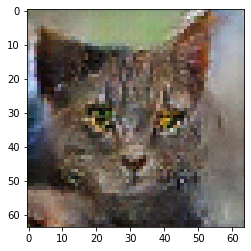

In [5]:
# Generate a random point, and an image from it
# this will be the goal image
tf.random.set_seed(195)
starter_image_noise = tf.random.normal([1, latent_dim])
starter_image = generator(starter_image_noise, training=False)[0][0]
plt.imshow(denormalize_image(starter_image))

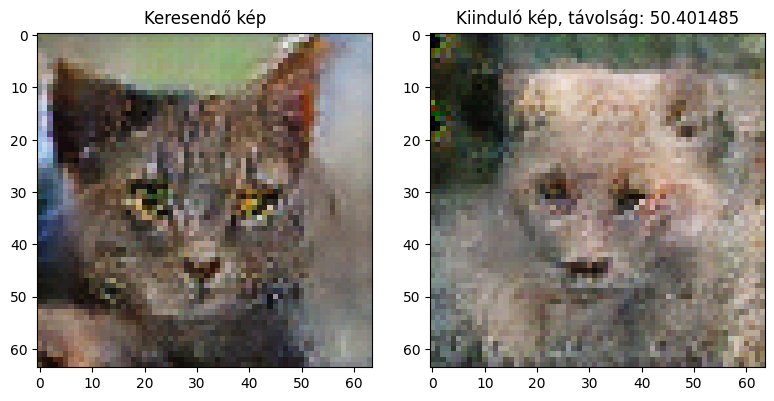

In [6]:
# generate a random starting point
random_noise = tf.random.uniform([1, latent_dim], minval=-1, maxval=1)

# generating an image from the random point
# and calculating the distance between the goal and the random image
random_image = generator(random_noise ,training=False)[0][0]

distance = tf.norm(starter_image-random_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(starter_image), interpolation='none')

axes[1].set_title("Kiinduló kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(random_image), interpolation='none')

In [7]:
# Gradient Descent

def gradient_descent(goal_image, starting_noise, step_size, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')
    losses = []
    for i in range(steps):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        noise = noise - (step_size * gradients)

        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    generated_image = generator(noise, training=False)[0][0]
    loss = tf.norm(goal_image - generated_image)
    losses.append(loss)
    return noise, losses

In [8]:
# Gradient Descent with Momentum

def gradient_descent_momentum(goal_image, starting_noise, step_size, momentum, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')

    change = 0
    losses = []
    for i in range(steps):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        change = (step_size * gradients) + momentum * change
        noise = noise - change
        
        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    generated_image = generator(noise, training=False)[0][0]
    loss = tf.norm(goal_image - generated_image)
    losses.append(loss)
    return noise, losses

Step: 0, Loss: 50.401485443115234


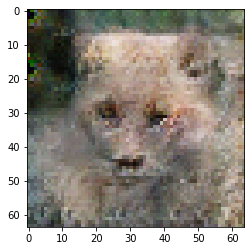

Step: 1, Loss: 38.46782302856445


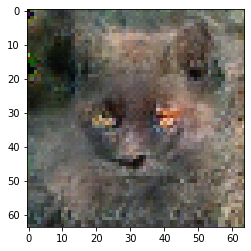

Step: 2, Loss: 35.35603713989258


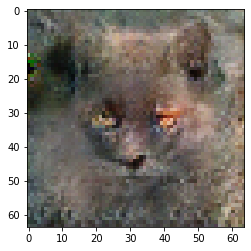

Step: 3, Loss: 33.5740966796875


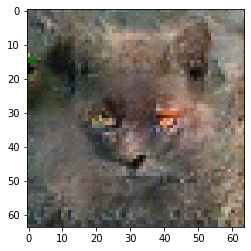

Step: 4, Loss: 32.111900329589844


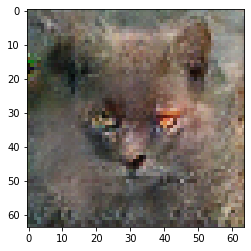

Step: 5, Loss: 30.954280853271484


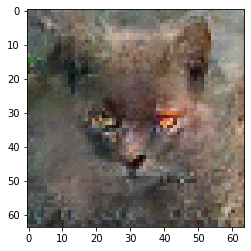

Step: 6, Loss: 30.288827896118164


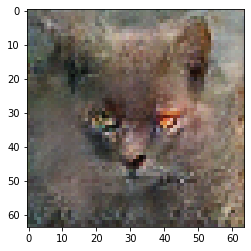

Step: 7, Loss: 29.772703170776367


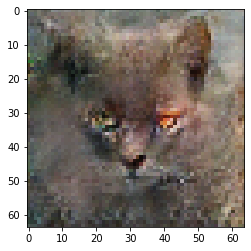

Step: 8, Loss: 29.363126754760742


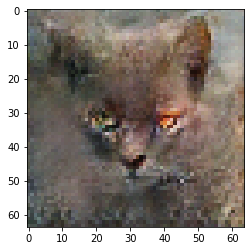

Step: 9, Loss: 28.78212547302246


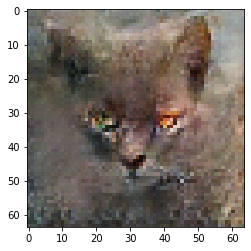

Step: 10, Loss: 28.257997512817383


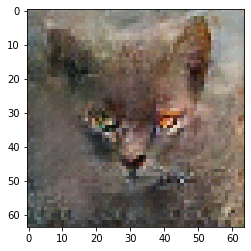

Step: 11, Loss: 27.812807083129883


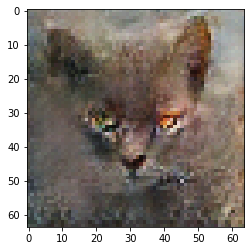

Step: 12, Loss: 27.412517547607422


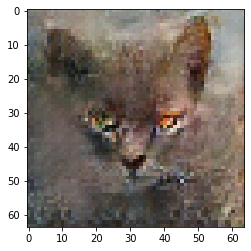

Step: 13, Loss: 26.921154022216797


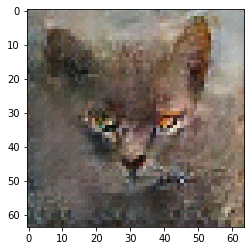

Step: 14, Loss: 26.378156661987305


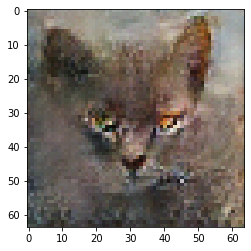

Step: 15, Loss: 25.878089904785156


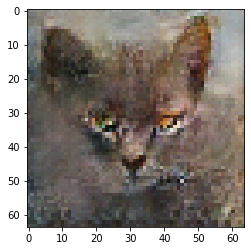

Step: 16, Loss: 25.423175811767578


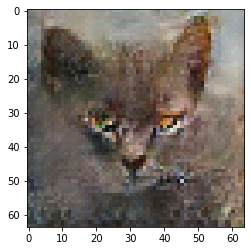

Step: 17, Loss: 25.00627899169922


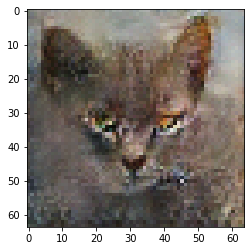

Step: 18, Loss: 24.634252548217773


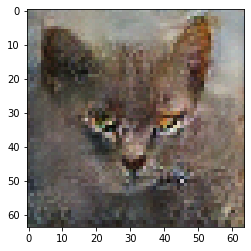

Step: 19, Loss: 24.307174682617188


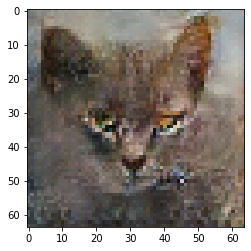

Step: 20, Loss: 24.00670051574707


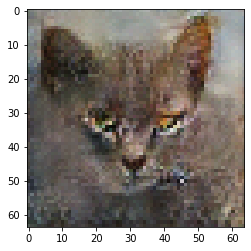

Step: 21, Loss: 23.690671920776367


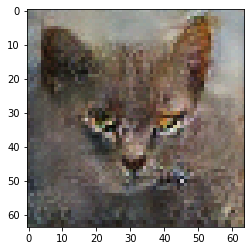

Step: 22, Loss: 23.376127243041992


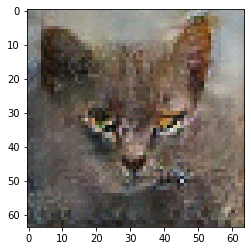

Step: 23, Loss: 23.071043014526367


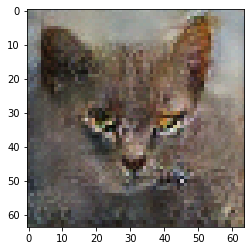

Step: 24, Loss: 22.790307998657227


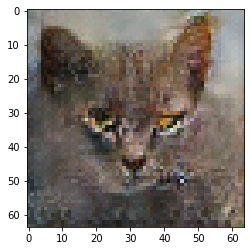

Step: 25, Loss: 22.52735137939453


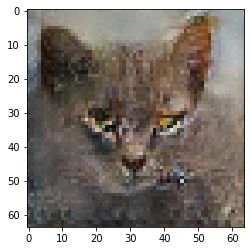

Step: 26, Loss: 22.266529083251953


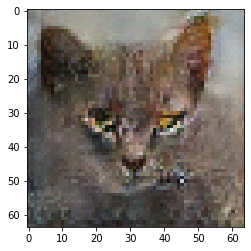

Step: 27, Loss: 22.02076530456543


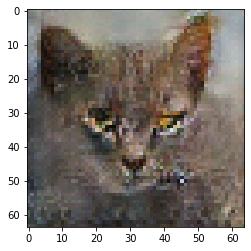

Step: 28, Loss: 21.781389236450195


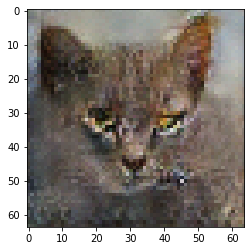

Step: 29, Loss: 21.54604721069336


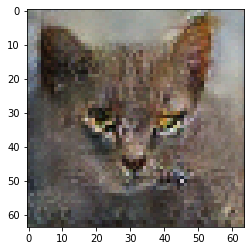

Step: 30, Loss: 21.308002471923828


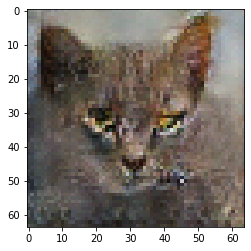

Step: 31, Loss: 21.069686889648438


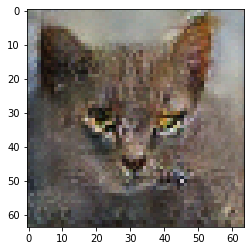

Step: 32, Loss: 20.850574493408203


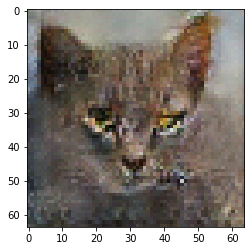

Step: 33, Loss: 20.63536262512207


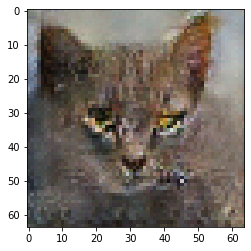

Step: 34, Loss: 20.440364837646484


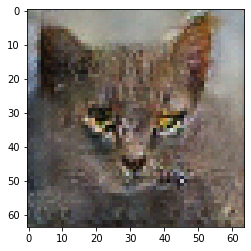

Step: 35, Loss: 20.235984802246094


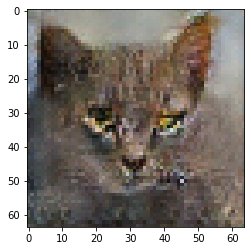

Step: 36, Loss: 20.020832061767578


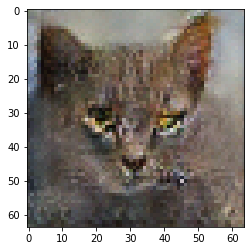

Step: 37, Loss: 19.817432403564453


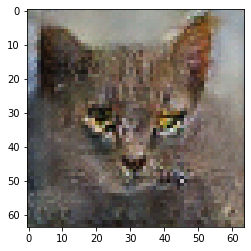

Step: 38, Loss: 19.616575241088867


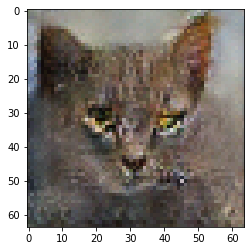

Step: 39, Loss: 19.409069061279297


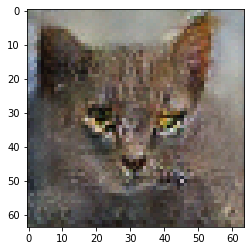

Step: 40, Loss: 19.2027530670166


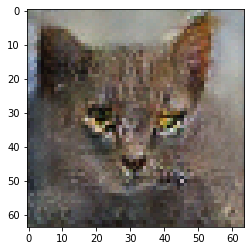

Step: 41, Loss: 18.985816955566406


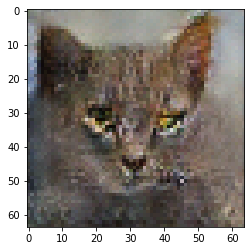

Step: 42, Loss: 18.768592834472656


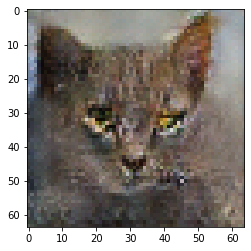

Step: 43, Loss: 18.5542049407959


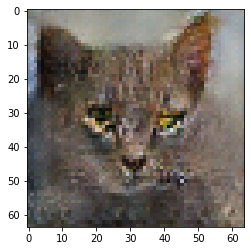

Step: 44, Loss: 18.348037719726562


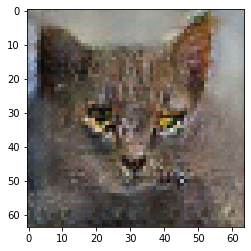

Step: 45, Loss: 18.14824676513672


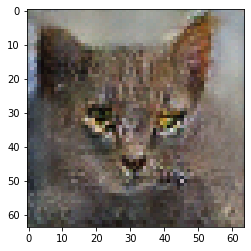

Step: 46, Loss: 17.920719146728516


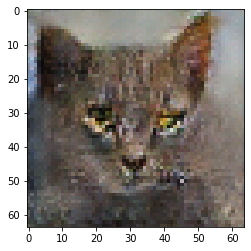

Step: 47, Loss: 17.705772399902344


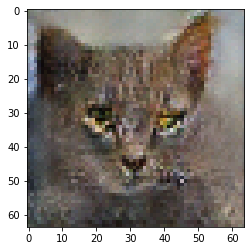

Step: 48, Loss: 17.51213836669922


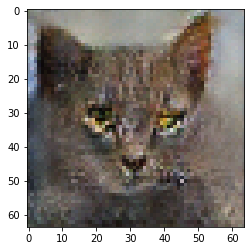

Step: 49, Loss: 17.380037307739258


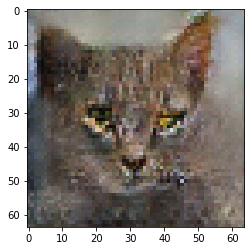

Step: 50, Loss: 17.20669937133789


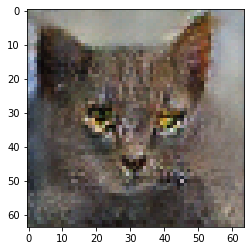

Step: 51, Loss: 17.24787712097168


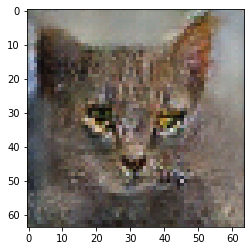

Step: 52, Loss: 17.304792404174805


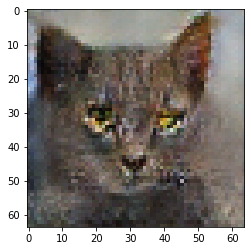

Step: 53, Loss: 17.862281799316406


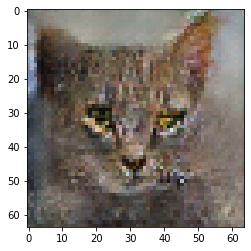

Step: 54, Loss: 17.609312057495117


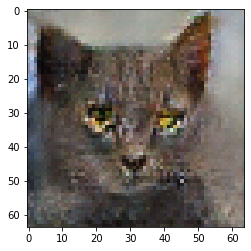

Step: 55, Loss: 18.474943161010742


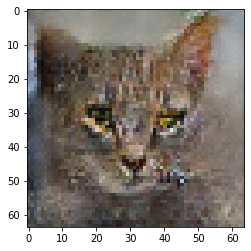

Step: 56, Loss: 17.88421630859375


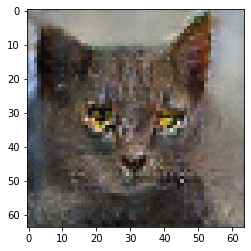

Step: 57, Loss: 18.88808822631836


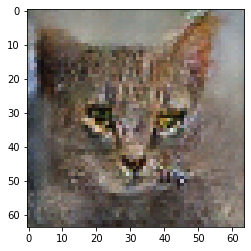

Step: 58, Loss: 17.327564239501953


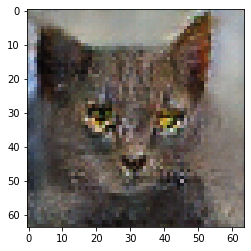

Step: 59, Loss: 18.100072860717773


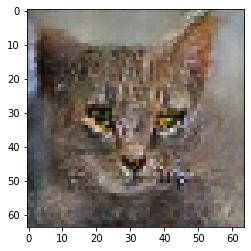

Step: 60, Loss: 17.1090087890625


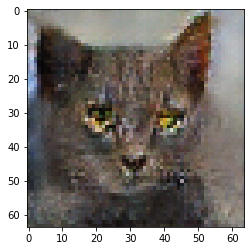

Step: 61, Loss: 18.152475357055664


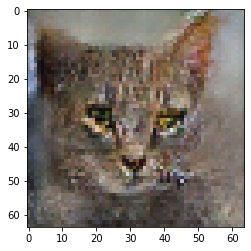

Step: 62, Loss: 16.78999137878418


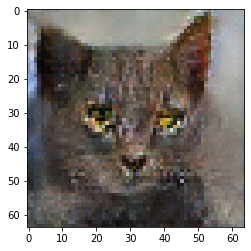

Step: 63, Loss: 17.93743896484375


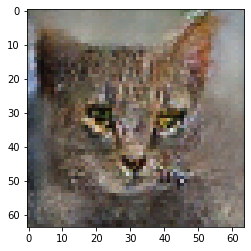

Step: 64, Loss: 16.838184356689453


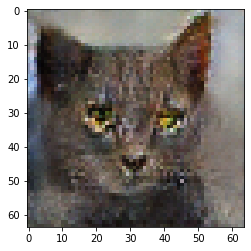

Step: 65, Loss: 18.00790023803711


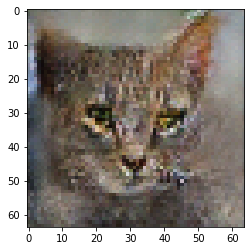

Step: 66, Loss: 16.556270599365234


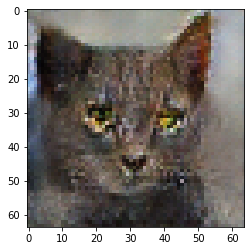

Step: 67, Loss: 18.027040481567383


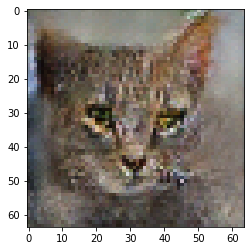

Step: 68, Loss: 15.916642189025879


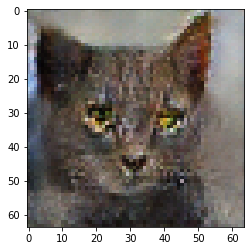

Step: 69, Loss: 17.302602767944336


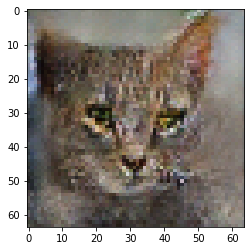

In [9]:
gradient_noise, gd_losses = gradient_descent(starter_image, random_noise, step_size=0.05, steps=70, verbose=True)

In [10]:
gradient_momentum_noise, gdm_losses =\
    gradient_descent_momentum(starter_image, random_noise, step_size=0.03, momentum=0.9, steps=70)

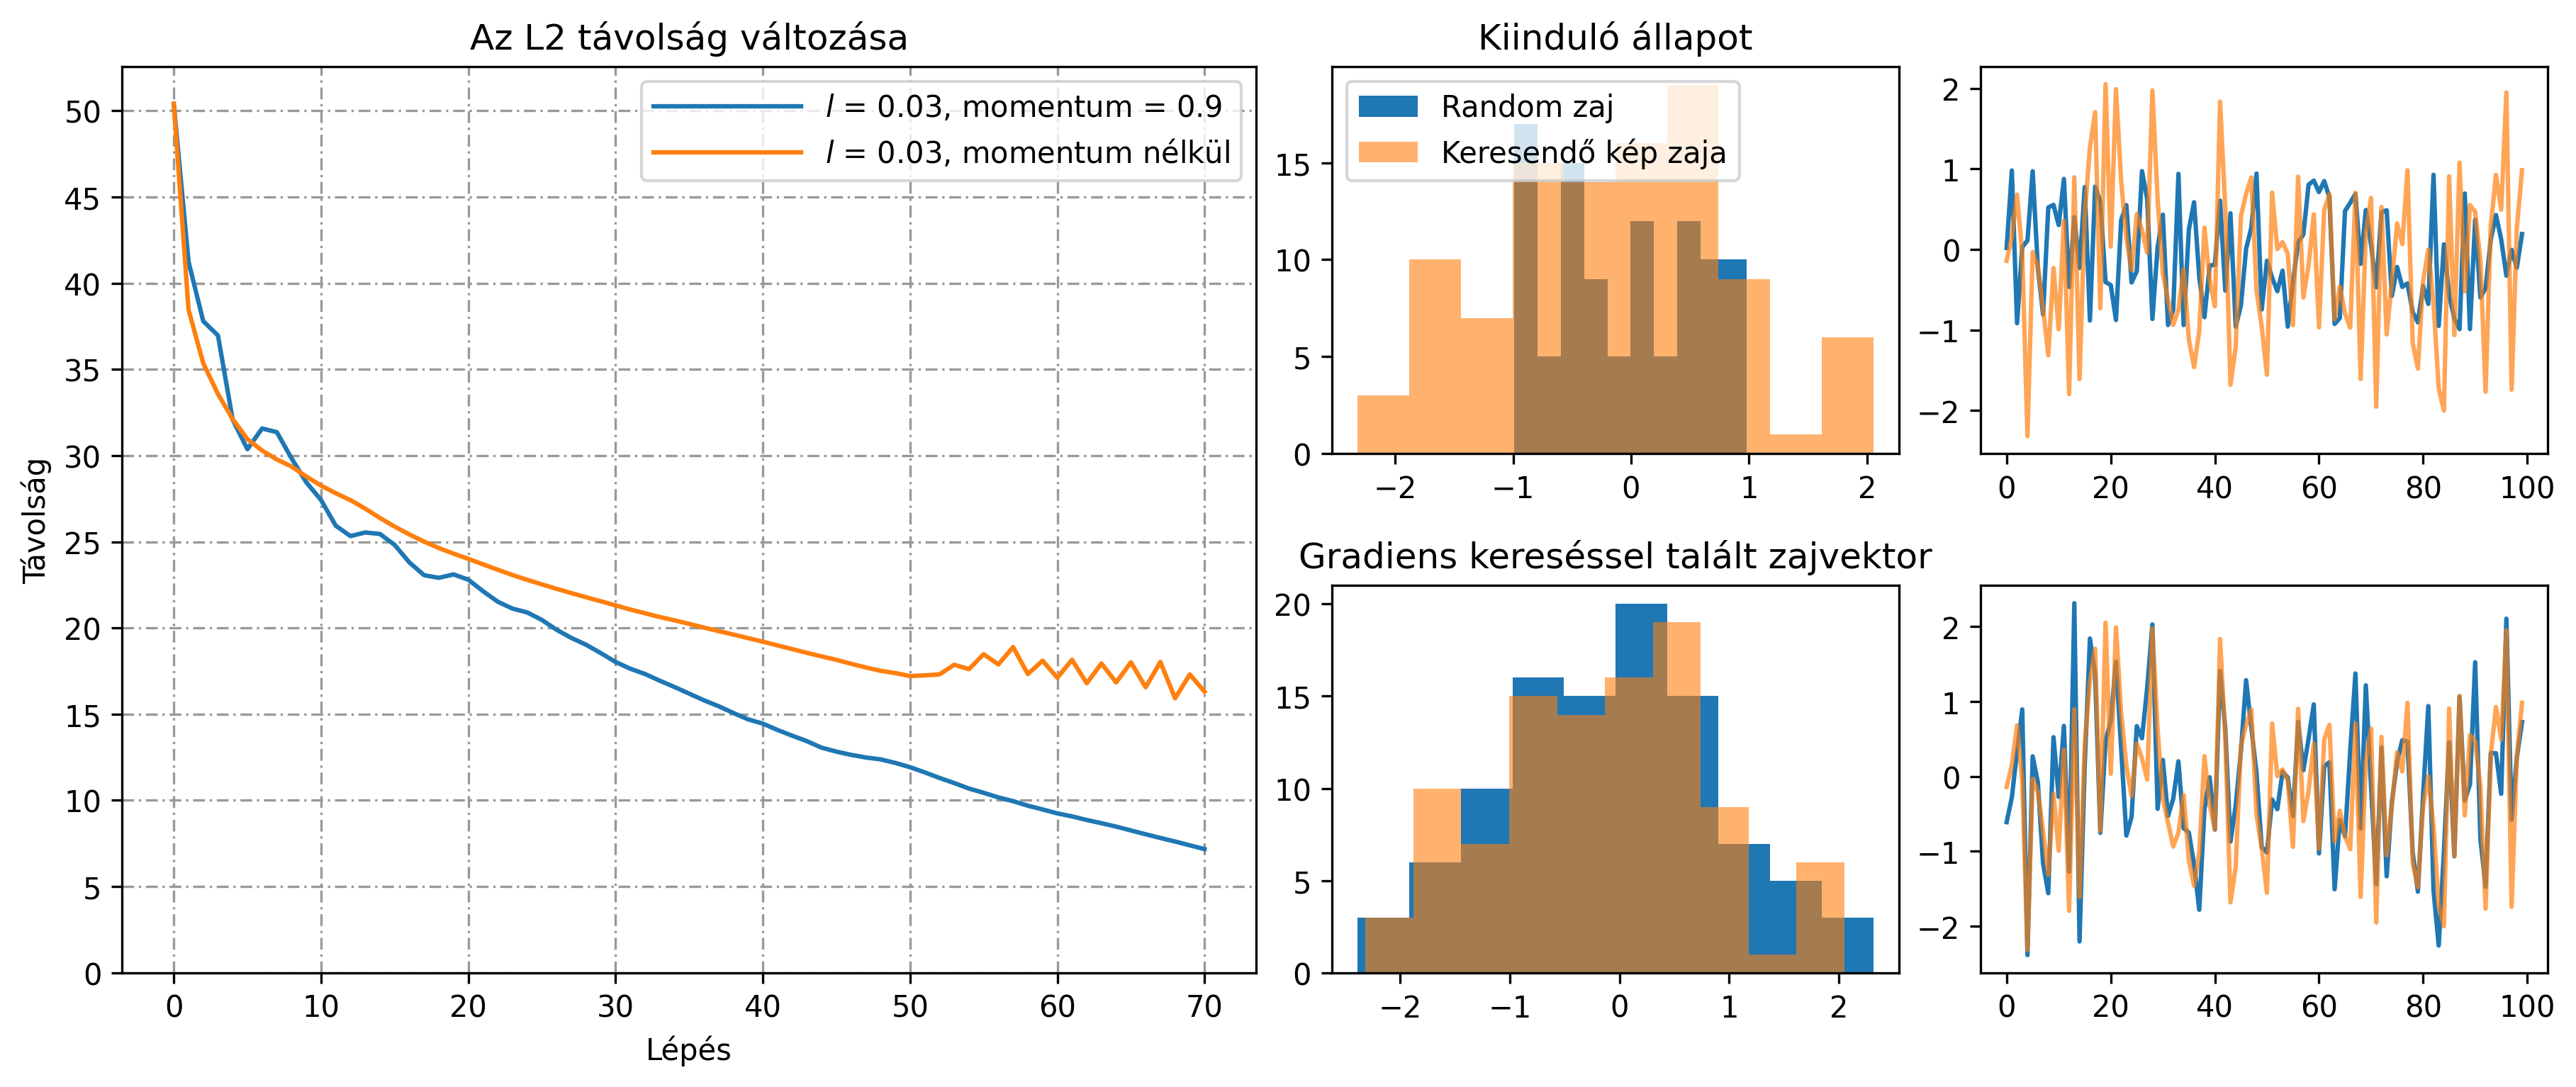

In [11]:
fig = plt.figure(figsize=(12, 5), dpi=300, constrained_layout=True)
axs = fig.subplot_mosaic([['Losses', 'TopRight', 'TopRight2'],['Losses', 'BottomRight', 'BottomRight2']],
                          gridspec_kw={'width_ratios':[2, 1, 1]})
axs['Losses'].set_xlabel('Lépés')
axs['Losses'].set_ylabel('Távolság')
axs['Losses'].set_title('Az L2 távolság változása')

axs['Losses'].grid(True, color='0.6', dashes=(5, 2, 1, 2))

axs['Losses'].plot(gdm_losses, label="$l$ = 0.03, momentum = 0.9")
axs['Losses'].plot(gd_losses, label="$l$ = 0.03, momentum nélkül")
axs['Losses'].set_ylim(bottom=0)
axs['Losses'].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs['Losses'].xaxis.set_major_locator(ticker.MultipleLocator(10))
axs['Losses'].legend(loc=0, handlelength=5)


axs['TopRight'].set_title("Kiinduló állapot")
axs['TopRight'].hist(random_noise.numpy().flatten(), label="Random zaj")
axs['TopRight'].hist(starter_image_noise.numpy().flatten(), alpha=0.6, label="Keresendő kép zaja")
axs['TopRight'].legend(loc=2)

axs['TopRight2'].plot(random_noise.numpy().flatten())
axs['TopRight2'].plot(starter_image_noise.numpy().flatten(), alpha=0.7)

axs['BottomRight'].set_title("Gradiens kereséssel talált zajvektor")
axs['BottomRight'].hist(gradient_momentum_noise.numpy().flatten())
axs['BottomRight'].hist(starter_image_noise.numpy().flatten(), alpha=0.6)

axs['BottomRight2'].plot(gradient_momentum_noise.numpy().flatten())
axs['BottomRight2'].plot(starter_image_noise.numpy().flatten(), alpha=0.7)
plt.show()

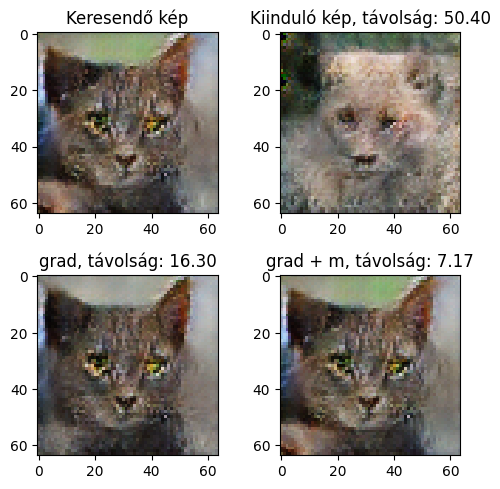

In [12]:
grad_image = generator(gradient_noise, training=False)[0][0]

grad_momentum_image = generator(gradient_momentum_noise, training=False)[0][0]

distance_grad = tf.norm(starter_image - grad_image)
distance_grad_momentum = tf.norm(starter_image - grad_momentum_image)

fig, axes = plt.subplots(figsize=(5, 5), nrows=2, ncols=2, dpi=100)
plt.tight_layout()
axes[0, 0].set_title("Keresendő kép")
axes[0, 0].imshow(denormalize_image(starter_image), interpolation='none')

axes[0, 1].set_title("Kiinduló kép" + ", távolság: " + '{0:.2f}'.format(distance.numpy()))
axes[0, 1].imshow(denormalize_image(random_image), interpolation='none')

axes[1, 0].set_title("grad" + ", távolság: " + '{0:.2f}'.format(distance_grad.numpy()))
axes[1, 0].imshow(denormalize_image(grad_image), interpolation='none')

axes[1, 1].set_title("grad + m" + ", távolság: " + '{0:.2f}'.format(distance_grad_momentum.numpy()))
axes[1, 1].imshow(denormalize_image(grad_momentum_image), interpolation='none')

## Validációs halmazban szereplő kép legközeli generált képének megtatálása

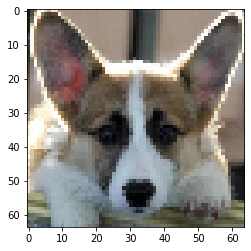

In [12]:
validating_image = plt.imread("./datas/afhq/val/dog/flickr_dog_000212.jpg")

# Resize it to 64x64
resized = tf.image.resize(validating_image, [64, 64])

resized = (resized - 127.5) / 127.5  # Normalize image

plt.imshow(denormalize_image(resized))

Step: 0, Loss: 72.26985168457031


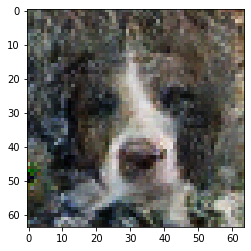

Step: 1, Loss: 64.40200805664062


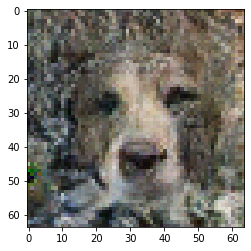

Step: 2, Loss: 58.41245651245117


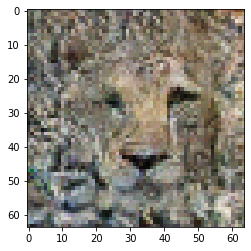

Step: 3, Loss: 59.45732879638672


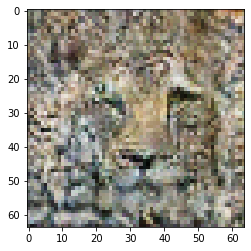

Step: 4, Loss: 60.226192474365234


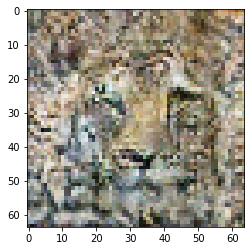

Step: 5, Loss: 59.0504150390625


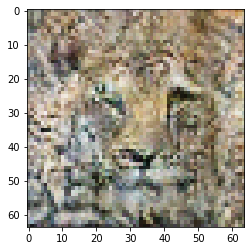

Step: 6, Loss: 57.055335998535156


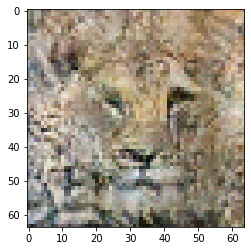

Step: 7, Loss: 55.01220703125


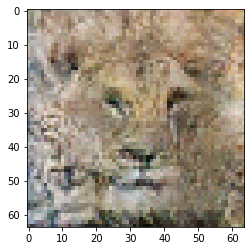

Step: 8, Loss: 52.854190826416016


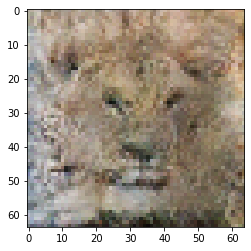

Step: 9, Loss: 50.32481002807617


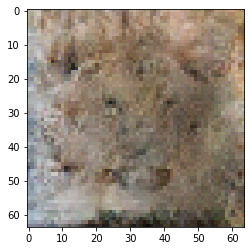

Step: 10, Loss: 48.126434326171875


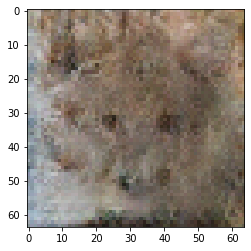

Step: 11, Loss: 46.966007232666016


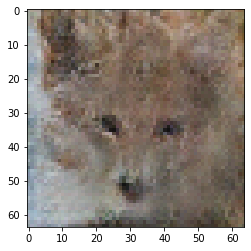

Step: 12, Loss: 46.630741119384766


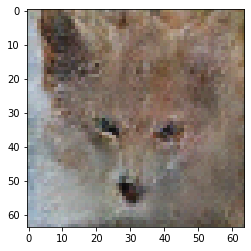

Step: 13, Loss: 46.306156158447266


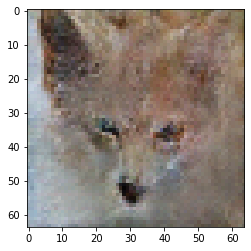

Step: 14, Loss: 46.246543884277344


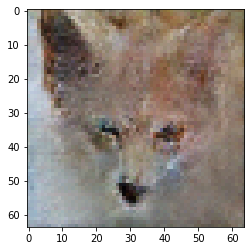

Step: 15, Loss: 45.925132751464844


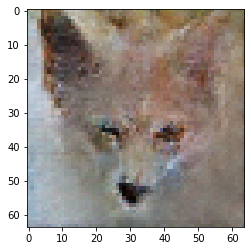

Step: 16, Loss: 45.34053039550781


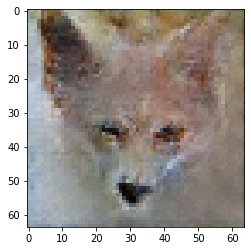

Step: 17, Loss: 44.7218017578125


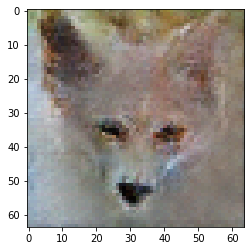

Step: 18, Loss: 44.30326843261719


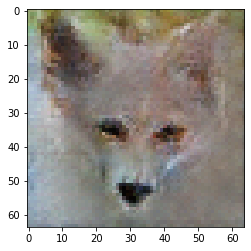

Step: 19, Loss: 44.0941162109375


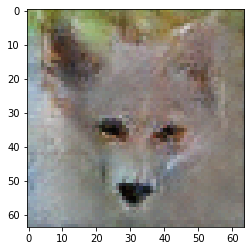

Step: 20, Loss: 43.93448257446289


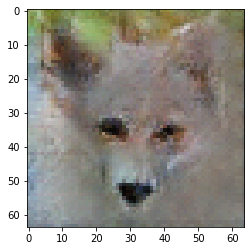

Step: 21, Loss: 43.803157806396484


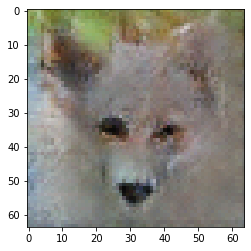

Step: 22, Loss: 43.762271881103516


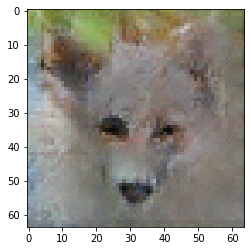

Step: 23, Loss: 43.73427200317383


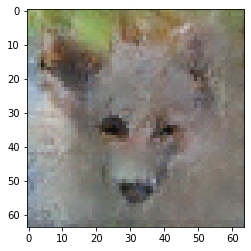

Step: 24, Loss: 43.56069564819336


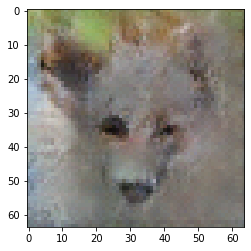

Step: 25, Loss: 43.2089958190918


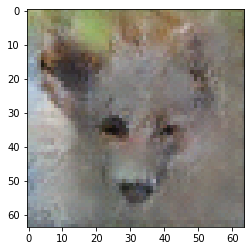

Step: 26, Loss: 42.81914138793945


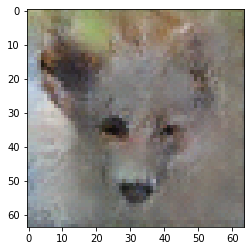

Step: 27, Loss: 42.44114685058594


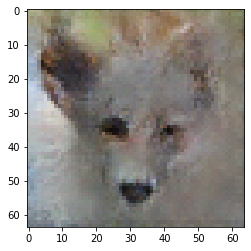

Step: 28, Loss: 42.13528060913086


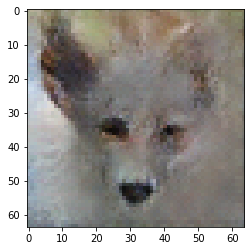

Step: 29, Loss: 41.9576416015625


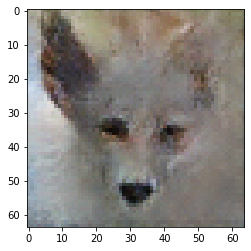

Step: 30, Loss: 41.886619567871094


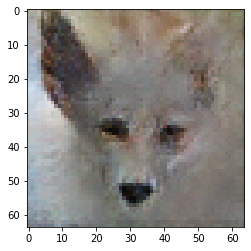

Step: 31, Loss: 41.739444732666016


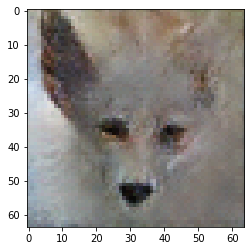

Step: 32, Loss: 41.497928619384766


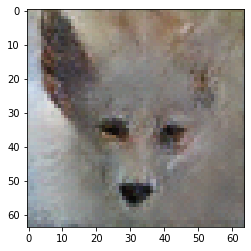

Step: 33, Loss: 41.19036865234375


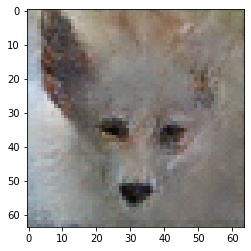

Step: 34, Loss: 40.91473388671875


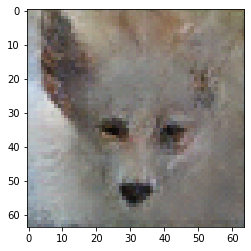

Step: 35, Loss: 40.687435150146484


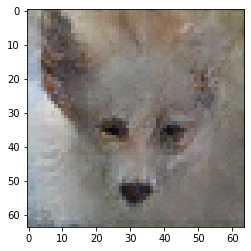

Step: 36, Loss: 40.491668701171875


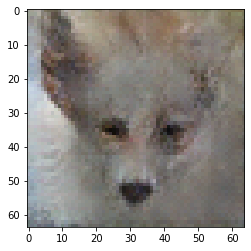

Step: 37, Loss: 40.34270477294922


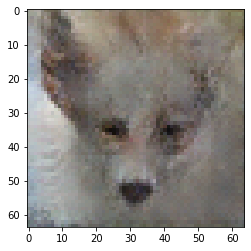

Step: 38, Loss: 40.1669807434082


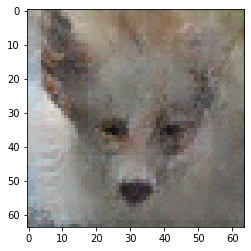

Step: 39, Loss: 39.85490798950195


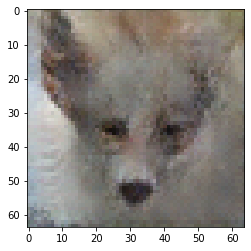

Step: 40, Loss: 39.50916290283203


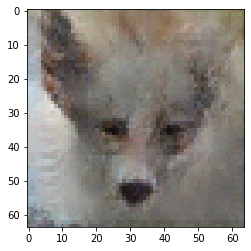

Step: 41, Loss: 39.14655685424805


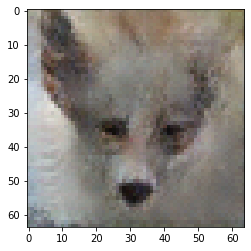

Step: 42, Loss: 38.77967834472656


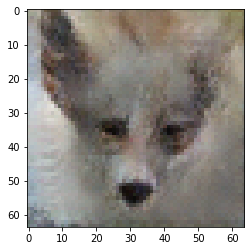

Step: 43, Loss: 38.344825744628906


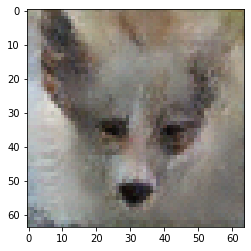

Step: 44, Loss: 37.9463005065918


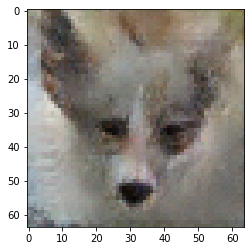

Step: 45, Loss: 37.615299224853516


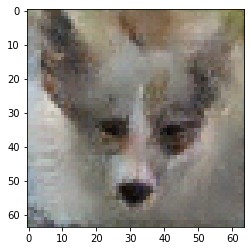

Step: 46, Loss: 37.40282440185547


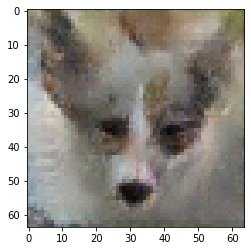

Step: 47, Loss: 37.18243408203125


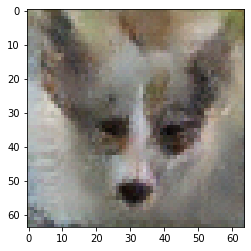

Step: 48, Loss: 37.0212287902832


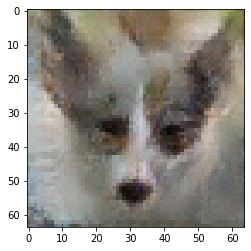

Step: 49, Loss: 36.99039840698242


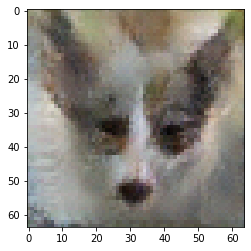

Step: 50, Loss: 37.008079528808594


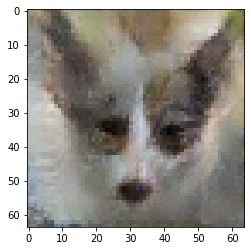

Step: 51, Loss: 36.91539764404297


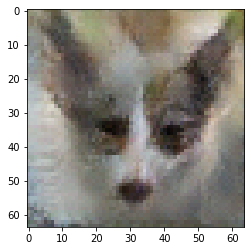

Step: 52, Loss: 36.74404525756836


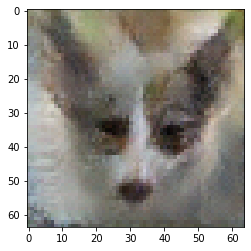

Step: 53, Loss: 36.547637939453125


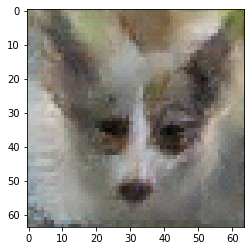

Step: 54, Loss: 36.29646301269531


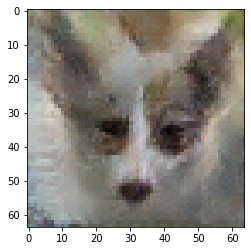

Step: 55, Loss: 36.06980895996094


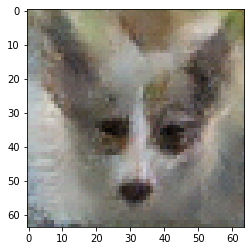

Step: 56, Loss: 35.91279220581055


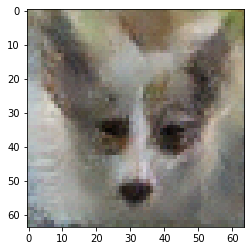

Step: 57, Loss: 35.853607177734375


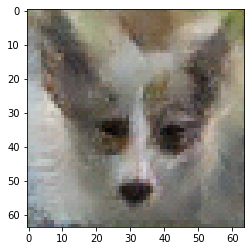

Step: 58, Loss: 35.8259391784668


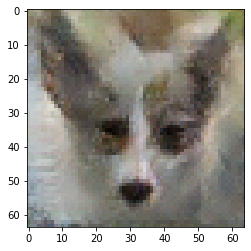

Step: 59, Loss: 35.76962661743164


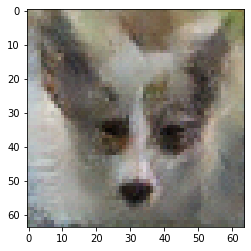

Step: 60, Loss: 35.66328811645508


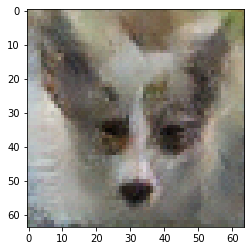

Step: 61, Loss: 35.558353424072266


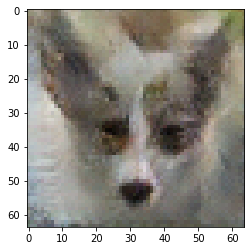

Step: 62, Loss: 35.43455505371094


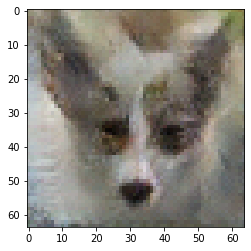

Step: 63, Loss: 35.304542541503906


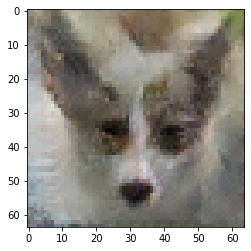

Step: 64, Loss: 35.20363998413086


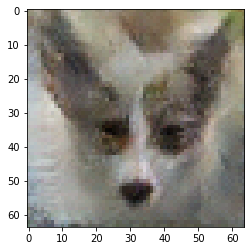

Step: 65, Loss: 35.130943298339844


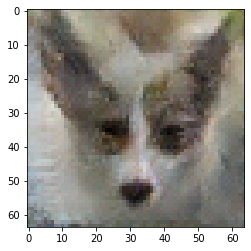

Step: 66, Loss: 35.037818908691406


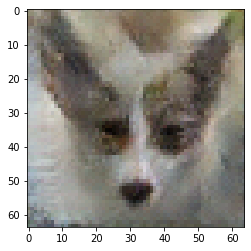

Step: 67, Loss: 34.942813873291016


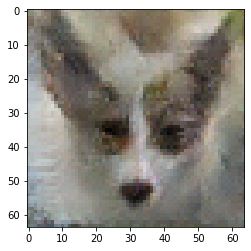

Step: 68, Loss: 34.8616828918457


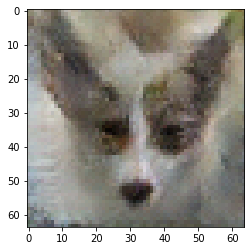

Step: 69, Loss: 34.77506637573242


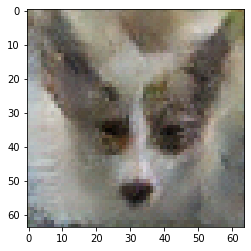

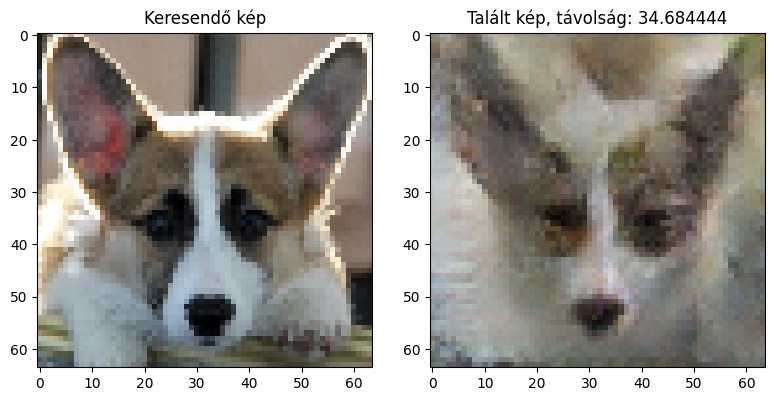

In [15]:
tf.random.set_seed(26)
noise = tf.random.uniform([1, latent_dim], minval=-1, maxval=1)

found_noise, _ = gradient_descent_momentum(resized, noise, step_size=0.03, momentum=0.9, steps=70, verbose=True)

found_image = generator(found_noise, training=False)[0][0]

distance = tf.norm(resized - found_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(resized), interpolation='none')

axes[1].set_title("Talált kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(found_image), interpolation='none')